Note: needs the questions.json file in the same directory as this file.
It should contain all of the questions in the database dumped from mongodb.

In [1]:
from collections import Counter
import json
from math import log
import numpy as np
from nltk.stem import PorterStemmer
from tqdm import tqdm

np.random.seed(0)

In [2]:
def bag_of_words(text, dictionary):
    bag = [0] * len(dictionary)
    for word in text:
        if word in dictionary:
            bag[dictionary[word]] += 1

    return bag

def generate_dictionary(subcategory_questions):
    """
    Generate dictionary for bag of words
    """

    dictionary = set()
    for subcat in subcategory_questions:
        for question in subcategory_questions[subcat]:
            dictionary.update(question)

    dictionary = list(dictionary)
    dictionary = {dictionary[i]: i for i in range(len(dictionary))}
    return dictionary

def naive_bayes(tokens, naive_bayes_data, class_priors):
    counts = Counter(tokens)

    # class priors
    sums = {
        subcat: log(class_priors[subcat])
        for subcat in class_priors
    }

    # likelihoods
    for subcat in class_priors:
        sums[subcat] += sum([
            # use laplace smoothing
            counts[token] * log(((naive_bayes_data[token][subcat] if token in naive_bayes_data else 0) + 1) / (class_priors[subcat] + 1))
            for token in counts
        ])

    return max(sums, key=sums.get)

def sparse_bag_of_words(text, dictionary):
    """
    Generate a sparse bag of words.
    Has the same effect as calling `sparsify(bag_of_words(text, dictionary))`, but is much more memory and time efficient.
    """

    bag = {dictionary[word]: 0 for word in text if word in dictionary}
    for word in text:
        if word in dictionary:
            bag[dictionary[word]] += 1

    return bag

def sparsify(vector):
    return {index: count for index, count in enumerate(vector) if not count == 0}

def removePunctuation(s, punctuation='''.,!-;:'"\/?@#$%^&*_~()[]{}“”‘’'''):
    return ''.join(ch for ch in s if ch not in punctuation)

In [3]:
ps = PorterStemmer()

with open('stop-words.txt') as f:
    stop_words = set(f.readlines())
    stop_words = set([word.strip() for word in stop_words])

with open('subcategories.txt') as f:
    SUBCATEGORIES = [line.strip() for line in f.readlines()]

questions = open('tossups.json').readlines() + open('bonuses.json').readlines()
np.random.shuffle(questions)
print('Number of questions:', len(questions))

Number of questions: 237637


`naive_bayes_data` has the form

```python
{
    "word": {
        "subcategory": count,
        ...
    },
    ...
}
```

where `subcategory` is a string, `word` is a string, and `count` is an integer.

In [5]:
subcategory_questions = {subcat: [] for subcat in SUBCATEGORIES}
naive_bayes_data = {}
class_priors = {subcat: 0 for subcat in SUBCATEGORIES}

for line in tqdm(questions[int(0.2*len(questions)):]):
    data = json.loads(line)

    if 'subcategory' not in data: continue
    subcategory = data['subcategory']
    if subcategory not in SUBCATEGORIES: continue

    if data['type'] == 'tossup' and 'question' in data and 'answer' in data:
        tokens = removePunctuation(data['question'] + ' ' + data['answer']).lower().split()
    if data['type'] == 'bonus' and 'leadin' in data and 'parts' in data and 'answers' in data:
        tokens = removePunctuation(data['leadin'] + ' ' + ' '.join(data['parts']) + ' ' + ' '.join(data['answers'])).lower().split()

    tokens = [token for token in tokens if token not in stop_words]
    tokens = [ps.stem(token) for token in tokens]

    token_counter = Counter(tokens)

    for token in set(tokens):
        if token not in naive_bayes_data:
            naive_bayes_data[token] = {subcat: 0 for subcat in SUBCATEGORIES}

        naive_bayes_data[token][subcategory] += 1

    class_priors[subcategory] += 1

    # subcategory_questions[subcategory].append(tokens)

100%|██████████| 190110/190110 [04:28<00:00, 707.87it/s]


In [6]:
# dictionary = generate_dictionary(subcategory_questions)
# print('Size of dictionary:', len(dictionary), 'words')

In [7]:
# encodings = {
#     subcat: [bag_of_words(question, dictionary) for question in tqdm(subcategory_questions[subcat])]
#     for subcat in SUBCATEGORIES
# }

In [8]:
# encodings_sparse = {
#     subcat: [sparse_bag_of_words(vector, dictionary) for vector in tqdm(subcategory_questions[subcat])]
#     for subcat in SUBCATEGORIES
# }

In [9]:
import seaborn as sn
from sklearn.metrics import ConfusionMatrixDisplay
import time

print('=====Begin Testing=====')
time_now = time.perf_counter()

counter = 0
correct = 0
confusion_matrix = [
    [0 for _ in range(len(SUBCATEGORIES))]
    for _ in range(len(SUBCATEGORIES))
]

for line in questions[:int(0.2*len(questions))]:
    data = json.loads(line)
    if 'subcategory' not in data:
        continue

    counter += 1
    subcategory = data['subcategory']
    if subcategory not in SUBCATEGORIES:
        continue

    if data['type'] == 'tossup':
        text = data['question'] + ' ' + data['answer']
    elif data['type'] == 'bonus' and 'parts' in data and 'answers' in data:
        text = data['leadin'] + ' ' + ' '.join(data['parts']) + ' ' + ' '.join(data['answers'])
    else:
        continue

    text = removePunctuation(text).lower().split()
    tokens = [token for token in text if token not in stop_words]
    tokens = [ps.stem(token) for token in tokens]
    prediction = naive_bayes(tokens, naive_bayes_data, class_priors)
    subcategory_index = SUBCATEGORIES.index(subcategory)
    prediction_index = SUBCATEGORIES.index(prediction)

    confusion_matrix[subcategory_index][prediction_index] += 1

    if subcategory == prediction:
        correct += 1

    if counter % 10000 == 0:
        print(f'{correct}/{counter}')

print('=====End Testing=====')
print(f'Accuracy: {correct / counter} ({correct}/{counter})')
print('Time:', time.perf_counter() - time_now, 'seconds')

=====Begin Testing=====
7667/10000
15298/20000
22958/30000
30606/40000
=====End Testing=====
Accuracy: 0.7662055127257366 (36276/47345)
Time: 74.7178037300182 seconds


In [10]:
print('Confusion Matrix:')
for subcat, row in zip(SUBCATEGORIES, confusion_matrix):
    print(f'{subcat:20}', row)

Confusion Matrix:
American Literature  [2264, 139, 122, 162, 14, 5, 5, 0, 1, 0, 2, 1, 1, 7, 0, 32, 5, 17, 35, 15, 49, 6, 157]
British Literature   [78, 2158, 79, 57, 8, 8, 8, 4, 2, 0, 0, 2, 1, 7, 2, 13, 7, 19, 13, 6, 18, 1, 49]
European Literature  [42, 78, 1615, 68, 3, 3, 8, 1, 0, 0, 0, 2, 1, 1, 1, 16, 8, 13, 13, 2, 19, 3, 12]
World Literature     [43, 36, 39, 1247, 2, 3, 1, 9, 0, 2, 1, 0, 2, 0, 0, 10, 6, 20, 7, 2, 16, 2, 16]
American History     [52, 11, 3, 3, 2037, 29, 39, 44, 0, 0, 0, 1, 1, 4, 0, 21, 18, 4, 12, 26, 655, 81, 72]
Ancient History      [1, 3, 2, 3, 2, 508, 16, 11, 0, 0, 0, 0, 0, 2, 0, 0, 5, 2, 2, 2, 25, 5, 0]
European History     [9, 25, 21, 12, 70, 316, 2268, 104, 1, 1, 1, 1, 7, 11, 0, 36, 38, 4, 36, 26, 537, 87, 15]
World History        [6, 9, 4, 22, 33, 198, 69, 1602, 0, 0, 0, 0, 3, 3, 0, 9, 30, 8, 6, 9, 590, 108, 12]
Biology              [7, 4, 2, 4, 10, 1, 4, 0, 2200, 72, 16, 7, 36, 4, 0, 3, 6, 2, 7, 61, 58, 18, 22]
Chemistry            [3, 2, 1, 2, 1, 2, 3, 0, 36

<AxesSubplot:>

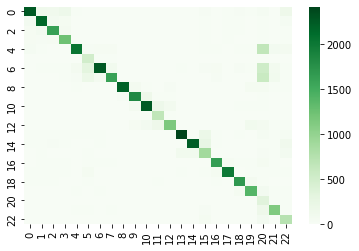

In [11]:
sn.heatmap(confusion_matrix, cmap='Greens', annot=False)